# Lab 1: Part c
In this final part of the lab we will explore Bayesian parameter estimation. The ML and MAP solutions only give a point estimate of the parameters; whereas, the Bayesian approach gives a full distribution over the parameter space. Additionally, by using a conjugate prior we are guaranteed a closed form expression for this posterior distribution over the parameters.

In [24]:
%load_ext autoreload
%autoreload 2

# For matrices
import numpy as np

# For plotting
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('font', size=15)

# Our custom modules
from normal import *
from log_normal import *
from normal_inv_gamma import *
from plot_normal import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Generate some data points from a normal distribution
mu = 1     # mean
sigma = 1  # standard deviation = sqrt(variance)
N = 5      # number of datapoints

X = mu + sigma*np.random.randn(N,1)

In [26]:
# parameters for prior - normal inverse gamma
alpha = 1
beta = 1
gamma = 1
delta = 0

## Parameters for posterior

### TODO 1
Define the parameters for the Bayesian posterior

In [27]:
# Replace this
gammaP = gamma + N
deltaP = (gamma*delta + np.sum(X))/(gamma + N)
alphaP = alpha + N/2
betaP = np.sum(X**2)/2 + beta + (gamma*delta**2)/2 - (gamma*delta + np.sum(X))**2 / (2*(gamma+N))

## ML + MAP parameter estimation of univariate normal

### TODO 2
Fill these equations from the previous section

In [38]:
# Replace this
muML = (1/N)*np.sum(X)
sigmaML = ((1/N)*np.sum((X-muML)*(X-muML)))**0.5
muMAP = np.sum(X)/(N+1)
sigmaMAP = ( (muMAP**2 + 2 + np.sum((X-muMAP)**2) )/(N+5) )**0.5

## Likelihood function

### TODO 3
Compute the posterior given the new closed form expression

In [70]:
sigma_range = np.linspace(0.02, 2., num=200)
mu_range = np.linspace(-2., 2., num=400)

conj_posterior = np.zeros((len(sigma_range), len(mu_range)))
lfun = np.zeros((len(sigma_range), len(mu_range)))
prior = np.zeros((len(sigma_range), len(mu_range)))

for i, m in enumerate(mu_range):
    for j, s in enumerate(sigma_range):
        lfun[j,i] = normal(X, m, s)
        prior[j,i] = normal_inv_gamma(alpha, beta, delta, gamma, m, s)
        
        # Replace this
        conj_posterior[j,i] = normal_inv_gamma(alphaP, betaP, deltaP, gammaP, m, s)

conj_posterior /= np.sum([np.sum(vec) for vec in conj_posterior]) #normalize

### TODO 4
Estimate the posterior as in `prac1_b` (brute force way)

In [71]:
posterior = np.zeros((len(sigma_range), len(mu_range)))
for i, _ in enumerate(mu_range):
    for j, _ in enumerate(sigma_range):
        posterior[j,i] = lfun[j,i]*prior[j,i]

posterior /= np.sum([np.sum(vec) for vec in posterior]) #normalize
# or posterior /= np.sum(np.array(posterior).reshape(-1,)) # normalize

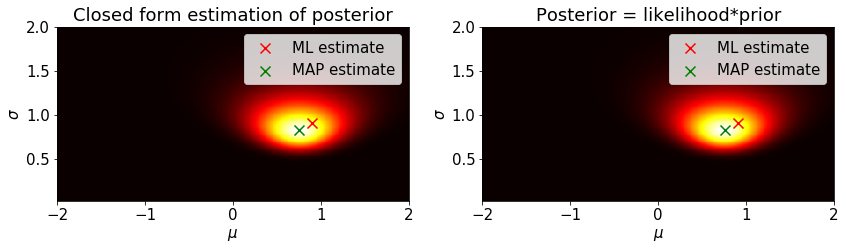

In [72]:
# Plot posterior
plt.subplot(1,2,1)
plt.imshow(conj_posterior, cmap="hot", origin="lower", 
           extent=[mu_range[0], mu_range[-1], sigma_range[0], sigma_range[-1]])
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Closed form estimation of posterior")

## Plot points
plt.scatter(muML, sigmaML, color='r', marker='x', s=100, label='ML estimate')
plt.scatter(muMAP, sigmaMAP, color='g', marker='x', s=100, label='MAP estimate')
plt.legend()


# Plot posterior
plt.subplot(1,2,2)
plt.imshow(posterior, cmap="hot", origin="lower",
           extent=[mu_range[0], mu_range[-1], sigma_range[0], sigma_range[-1]])
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Posterior = likelihood*prior")

## Plot points
plt.scatter(muML, sigmaML, color='r', marker='x', s=100, label='ML estimate')
plt.scatter(muMAP, sigmaMAP, color='g', marker='x', s=100, label='MAP estimate')
plt.legend()

plt.tight_layout()

### TODO 5
Empirically compare the closed form posterior to the product of likelihood and prior from `prac1_b`

max difference is 2.981555974335137e-19


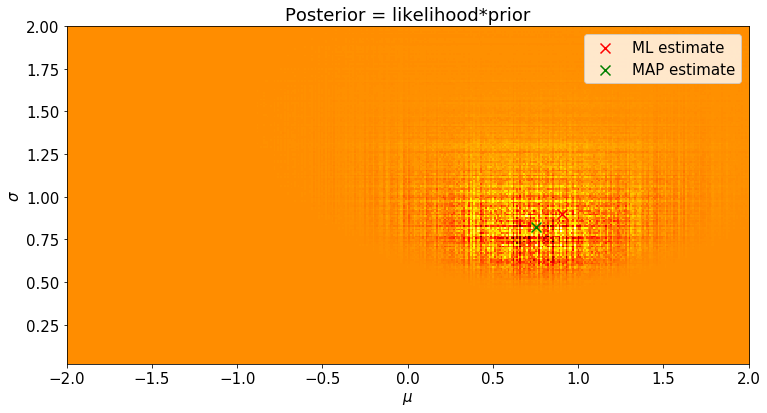

In [85]:

diff = np.zeros((len(sigma_range), len(mu_range)))
for i, _ in enumerate(mu_range):
    for j, _ in enumerate(sigma_range):
        diff[j,i] = posterior[j,i] - conj_posterior[j,i]
        
print( f"max difference is {max(np.array(diff).reshape(-1,))}")
# Plot posterior
plt.subplot(1,1,1)
plt.imshow(diff, cmap="hot", origin="lower",
           extent=[mu_range[0], mu_range[-1], sigma_range[0], sigma_range[-1]])
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("difference")

## Plot points
plt.scatter(muML, sigmaML, color='r', marker='x', s=100, label='ML estimate')
plt.scatter(muMAP, sigmaMAP, color='g', marker='x', s=100, label='MAP estimate')
plt.legend()

plt.tight_layout()

### TODO 6
Show that the peak of this distribution again corresponds to the MAP solution.

### BONUS TODO
Write code to estimate the probability that a new data point belongs to the same model. Compare the ML, MAP and fully Bayesian methods to do this. What are the advantages of using the Bayesian approach?

Text(0.5, 1.0, 'MAP & ML parameter fitted distribution')

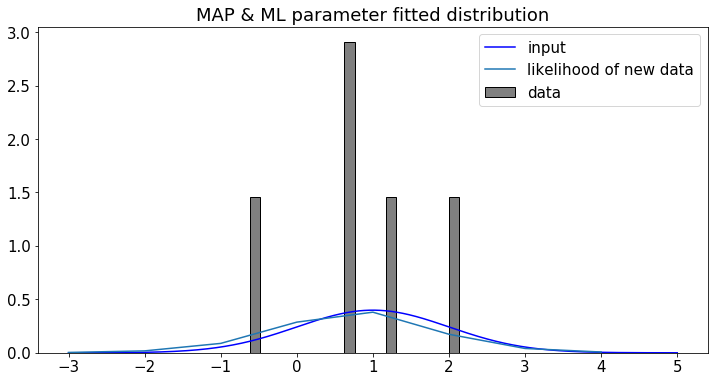

In [97]:
def belongs_to_posterior(x):
    prob = 0
    for i, m in enumerate(mu_range):
        for j, s in enumerate(sigma_range):
            prob += posterior[j,i] * normal((x,),m,s)
    return prob

prob = []
for x in range (-3,5,1):
    prob.append((x, belongs_to_posterior(x)))

# Plotting univariate normal
# Normalizing histograms - assuming bins are evenly sized
[hist_count, bin_edges] = np.histogram(X, 20)
bin_width = bin_edges[1] - bin_edges[0]
hist_pos = (bin_edges[1:] + bin_edges[:-1]) / 2.

# Plot figure
plt.bar(bin_edges[:-1], hist_count/(np.sum(hist_count)*bin_width), color='gray', 
        edgecolor='k', width=bin_width, label='data')
plot_normal(mu, sigma, 'b', 'input')
#plot_normal(muML, sigmaML, 'r', 'ML estimate')
#plot_normal(muMAP, sigmaMAP, 'g', 'MAP estimate')

plt.plot(*zip(*prob), label='likelihood of new data')

plt.legend()
plt.title('p(new data point belonging to same distr)')